In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import gpytorch
import torch
import pandas as pd
import importlib

# import GPGridSearch and utils
from dipper.model_utils.GPGridSearch import GPGridSearch
from dipper.data_utils.utils import *
from dipper.model_utils.utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Load data and inject an anomaly

Anomaly locations: [58]


/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))


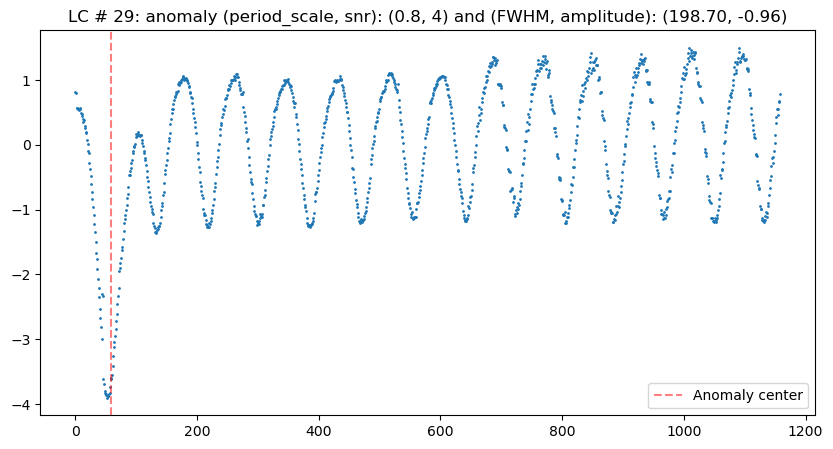

Anomaly locations:
[58]
4.072916666666667


In [2]:
# Data and anomaly parameters
file_number = 29
shape = "gaussian"
period_scale = 0.8
snr = 4

# Load the data
data_dir = '../data/k2/'
filename = f'k2_{file_number}.fits'
x, y, y_err = load_k2_data(data_dir + filename)

# Scale data to be between 0 and 1
y = (y - np.min(y)) / (np.max(y) - np.min(y))
y_err = y_err / (np.max(y) - np.min(y))

# Inject anomalies
steps, y, anomaly_locs, anomaly_amp, anomaly_fwhm = inject_anomaly(
    y, 
    num_anomalies=1, 
    seed=file_number, 
    shapes=[shape],
    period_scale=period_scale,
    snr=snr
)

# Narrow in to boundary right +500 and -500 inidices from loc, and sparisfy by 10
steps = np.array(range(len(x)))
# mask = np.logical_and(steps > loc - 300, steps < loc + 300)
mask = np.ones(len(x), dtype=bool)
x = x[mask][::3]
y = y[mask][::3]
y_err = y_err[mask][::3]

# Update anomaly_locs to mask
anomaly_bool_array = np.zeros(len(steps), dtype=bool)
for loc in anomaly_locs:
    anomaly_bool_array[int(loc):int(loc)+3] = True
anomaly_bool_array = anomaly_bool_array[mask][::3]
anomaly_locs = np.where(anomaly_bool_array)[0]
print("Anomaly locations:", anomaly_locs)

# Standardize data to have mean 0 and std of 1
mean_y = np.mean(y)
std_y = np.std(y)
y = (y - mean_y) / std_y
y_err = y_err / std_y

# Plot anomalies
plt.figure(figsize=(10,5))
plt.plot(range(len(x)), y, '.', markersize=2)
for i in range(len(anomaly_locs)):
    plt.axvline(x=anomaly_locs[i], color='r', linestyle='--', alpha=0.5, label='Anomaly center')
plt.legend()
plt.title(f"LC # {file_number}: anomaly (period_scale, snr): ({period_scale}, {snr}) and (FWHM, amplitude): ({anomaly_fwhm:.2f}, {anomaly_amp:.2f})")
plt.show()

# Print anomaly_locs, both indices and x[i]
print("Anomaly locations:")
print(anomaly_locs)
for i in anomaly_locs: print(x[int(i)])

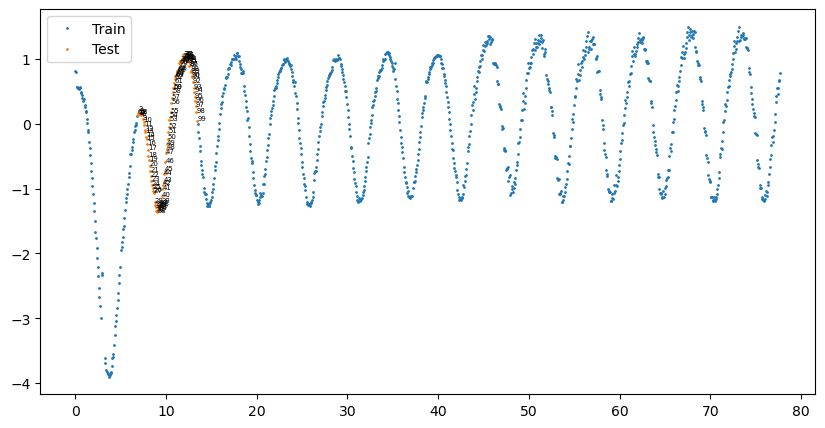

In [3]:
# Proof of concept in GPGridSearch, making sure it works as expected
start = 100
end = 200
mask = np.ones(len(x), dtype=bool)
mask[start:end] = False

x_train = x[mask]
y_train = y[mask]
y_err_train = y_err[mask]

# Create test data with interval
mask = ~mask
x_test = x[mask]
y_test = y[mask]
y_err_test = y_err[mask]

# Plot y_train and y_test against x
plt.figure(figsize=(10,5))
plt.plot(x_train, y_train, '.', markersize=2, label='Train')
plt.plot(x_test, y_test, '.', markersize=2, label='Test')
plt.legend()

for i in range(end - start):
    x_curr = x_test[i]
    y_curr = y_test[i]

    plt.text(x_curr, y_curr, f'{i}', fontsize=5, color='black')

# Perform grid search to find most anomalous interval

In [4]:
# Hyperparameters
min_anomaly_len = int(1 / (2 * np.median(np.diff(x))))  # Nyquist frequency
max_anomaly_len = int(0.1 * len(x))  # Max 10% of total time steps
window_slide_step = 20
window_size_step = 60
assume_independent = True
which_metric = 'mll'
initial_lengthscale = 0.5
training_iterations = 50
filename = f'../results/test.txt'

gp_detector = GPGridSearch(
    x,
    y,
    y_err,
    min_anomaly_len=min_anomaly_len,
    max_anomaly_len=max_anomaly_len,
    window_slide_step=window_slide_step,
    window_size_step=window_size_step,
    assume_independent=assume_independent,
    which_metric=which_metric,
    initial_lengthscale=initial_lengthscale,
)

print("Number of steps:", gp_detector.num_steps, "min anomaly length:", min_anomaly_len, "max anomaly length:", max_anomaly_len)
print("Number of anomaly intervals:", len(gp_detector.intervals))
print("First 10 anomaly intervals:", gp_detector.intervals[:10])

Number of steps: 1159 min anomaly length: 8 max anomaly length: 115
Number of anomaly intervals: 113
First 10 anomaly intervals: [(0, 8), (0, 68), (20, 28), (20, 88), (40, 48), (40, 108), (60, 68), (60, 128), (80, 88), (80, 148)]


In [5]:
# Find the best interval
gp_detector.find_anomalous_interval(device=device, training_iterations=training_iterations, filename=filename, silent=False)

/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


Anomaly interval: 0-8, mean metric over the interval: -1.1455588340759277


/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


Anomaly interval: 0-68, mean metric over the interval: -2.8719375133514404
Anomaly interval: 20-28, mean metric over the interval: -1.026487946510315
Anomaly interval: 20-88, mean metric over the interval: -3.504439353942871
Anomaly interval: 40-48, mean metric over the interval: -1.7027575969696045
Anomaly interval: 40-108, mean metric over the interval: -3.133235454559326
Anomaly interval: 60-68, mean metric over the interval: -1.579960584640503
Anomaly interval: 60-128, mean metric over the interval: -1.4523364305496216
Anomaly interval: 80-88, mean metric over the interval: -1.0729289054870605
Anomaly interval: 80-148, mean metric over the interval: -1.2658880949020386
Anomaly interval: 100-108, mean metric over the interval: -1.0373432636260986
Anomaly interval: 100-168, mean metric over the interval: -1.2774394750595093
Anomaly interval: 120-128, mean metric over the interval: -1.0730096101760864
Anomaly interval: 120-188, mean metric over the interval: -1.3230334520339966
Anomal

In [9]:
print("Best interval:", gp_detector.best_interval, "min metric:", gp_detector.min_metric)

# Find the 5 lowest mean_metric values and their related intervals
sorted_intervals = sorted(zip(gp_detector.mean_metrics, gp_detector.intervals), key=lambda x: x[0])

# Get the 5 lowest mean_metric values and their related intervals
lowest_5_intervals = sorted_intervals[:5]

# Print the results
for metric, interval in lowest_5_intervals:
    print(f"Interval: {interval}, Mean Metric: {metric}")

# Check identified anomalies
anomalous = np.zeros_like(y)

# Every interval in lowest_3_intervals is anomalous
for interval in lowest_5_intervals:
    start, end = interval[1]
    anomalous[start:end] = 1

# print np.where anomalous is 1
print(np.where(anomalous == 1))

Best interval: (20, 88) min metric: tensor(-3.5049, device='cuda:0', grad_fn=<DivBackward0>)
Interval: (20, 88), Mean Metric: -3.504884719848633
Interval: (40, 108), Mean Metric: -3.132479667663574
Interval: (0, 68), Mean Metric: -2.8718302249908447
Interval: (40, 48), Mean Metric: -1.702812910079956
Interval: (60, 68), Mean Metric: -1.5800046920776367
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107]),)


### Analyze

   start  end    metric
0      0    8 -1.145559
1      0   68 -2.871938
2     20   28 -1.026488
3     20   88 -3.504439
4     40   48 -1.702758
Best intervaL:    start  end    metric
3     20   88 -3.504439
Best 5 intervals:    start  end    metric
3     20   88 -3.504439
5     40  108 -3.133235
1      0   68 -2.871938
4     40   48 -1.702758
6     60   68 -1.579961


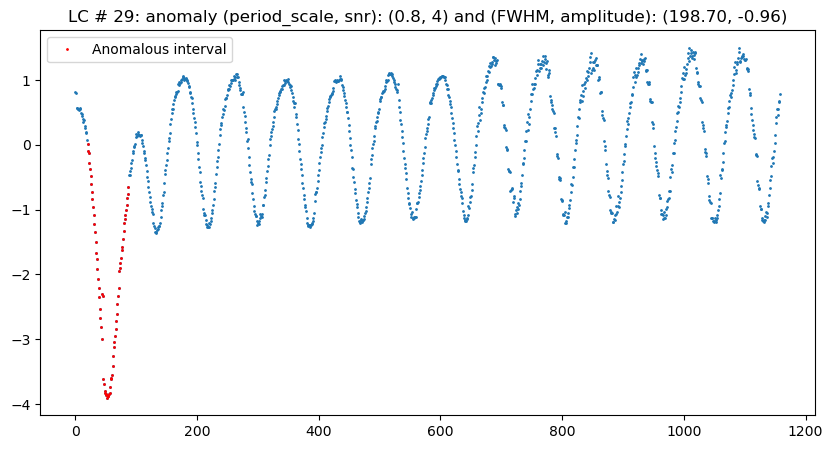

In [6]:
# results are stored in a txt file, with header: start,end,metric
data = pd.read_csv(filename, header=0, sep=",")
print(data.head())

# find the best metric start and end interval
best_metric = data["metric"].min()
best_interval = data[data["metric"] == best_metric]
start = int(best_interval["start"].values[0])
end = int(best_interval["end"].values[0])
best_5_intervals = data.sort_values(by="metric").head(5)
print(f"Best intervaL: {best_interval}")
print(f"Best 5 intervals: {best_5_intervals}")

# Plot anomalies
plt.figure(figsize=(10,5))
plt.plot(range(len(x)), y, '.', markersize=2)
plt.plot(range(start, end), y[start:end], '.', color='r', markersize=2, label='Anomalous interval')
plt.legend()
plt.title(f"LC # {file_number}: anomaly (period_scale, snr): ({period_scale}, {snr}) and (FWHM, amplitude): ({anomaly_fwhm:.2f}, {anomaly_amp:.2f})")
plt.show()

In [7]:
# Print the metric for the range with the center of the anomaly in the middle
print("Metric for the range overlapping the anomaly center:")
for loc in anomaly_locs:
    anomaly_overlap = data[(data["start"] <= loc) & (data["end"] >= loc)]
    best_anomaly_metric = anomaly_overlap["metric"].max()
    best_anomaly_interval = anomaly_overlap[anomaly_overlap["metric"] == best_anomaly_metric]
    print(best_anomaly_interval)

Metric for the range overlapping the anomaly center:
   start  end    metric
1      0   68 -2.871938
